# Заглянем глубже: смеи Гауссовых распределений
В этом разделе мы рассмотрим смеси Гауссовых распределений, которые можно рассматривать в качестве развития идей метода *k*-средних, но которые могут также стать мощным инструментом для статистических оценок, выходящих за пределы простой кластеризации.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Причины появления GMM: недостатки метода *k*-средних
Например, для случая простых "пятен" данных алгоритм *k*-средних позволяет быстро маркировать кластеры достаточно близко к тому, как мы бы маркировали их на глаз:

In [3]:
# Генерируем данные
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # Транспонируем для удобства оси координат

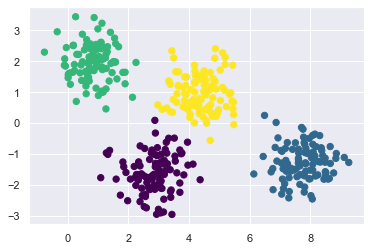

In [4]:
# Выводим данные на график с полученными методом k-средних метками
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

Модели *k*-средних можно рассматривать, в частности, как помещающую окружности (*или в пространствах большей размерности гиперсферы*) с центрами в центрах каждого из кластеров и радиусом, соответствующим расстоянию до наиболее удаленной точки кластера. Этот радиус задает жесткую границу соответствия точки кластеру в обучающей последовательности: все точки, находящиеся снаружи этой окружности, не считаются членами кластера.

In [5]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # Выводим на рисунок входные данные
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # Выводим на рисунок представление модели k-средних
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))


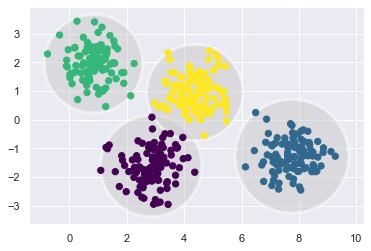

In [6]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

Немаловажный нюанс, касающийся метода *k*-средних, состоит в том, что эти модели кластеров *обязательно должны иметь форму окружностей*: метод *k*-средних не умеет работать с овальными или эллипсовидными кластерами. Так, например, если несколько преобразовать те же данные, присвоенные метки окажутся перепутаны:

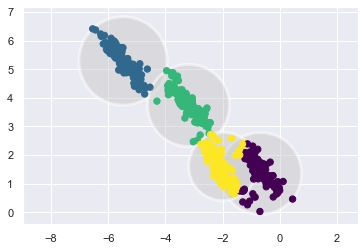

In [7]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

Отсутствие гипкости в вопросе формы кластеров и отсутствие вероятностного присвоения меток кластеров - два недостатка метода *k*-средних, означающих, что для многих наборов данных (особенно низкоразмерных) он будет работать не столь хорошо, как хотелось бы.

Можно попытаться избавиться от этих недостатков путем обобщения модели *k*-средних. Например, можно оценивать степень достоверности присвоения меток кластеров, сравнивая расстояние от каждой точки до *всех* центров кластеров, а не сосоредотачивая внимание лишь на ближайшем. Можно также разрешить эллипсовидную форму границ кластеров, а не только круглую, чтобы учесть кластеры некруглой формы. Это базовые составляющие другой разновидности метода кластеризации - смеси Гауссовых распределений.
## Обобщение ЕМ-модели: смеси Гауссовых распределений
Смесь Гауссовых распределений (gaussian mixture model, GMM) нацелена на поиск многомерных Гауссовых распределений вероятностей, моделирующих наилучшим возможным образом любой исходный набор данных.

В простейшем случае смеси Гауссовых распределений можно использовать для поиска кластеров аналогично методу *k*-средних:

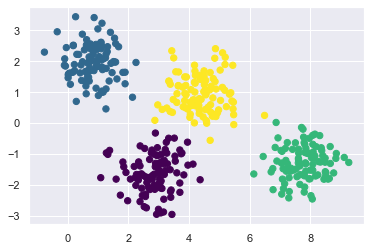

In [9]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

Но в силу того, что GMM содержит "под капотом" вероятностную модель, с ее помощью можно также присваивать метки кластеров на вероятностной основе:

In [10]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.    0.    0.469 0.531]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    0.    1.   ]
 [1.    0.    0.    0.   ]]


Для визуализации этой вероятности, можно сдлеать размеры точек пропорциональными степени достоверности их предсказания:

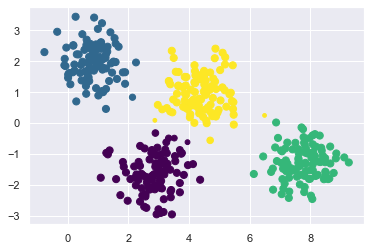

In [11]:
size = 50 * probs.max(1) ** 2  # Возведение в квадрат усиливает влияние различий
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

"Под капотом" смесь Гауссовых распределений очень напоминает метод *k*-средних: она использует подход с максимизацией математического ожидания, который с качественной точки зрения делает следующее.

1. Выбирает первоначальные гипотезы для расположения и формы кластеров.
2. Повторяет до достижения сходимости:
    1. ***Е-шаг*** - для каждой точки находит веса, кодирующие вероятность ее принадлежности к каждому кластеру;
    2. ***М-шаг*** - для каждого кластера корректирует его расположение, нормализаию и форму на основе информации обо *всех* точках данных с учетом весов.
    
В рещультате каждый кластер оказывается связан не со сферой с четкой границей, а с гладкой Гауссовой моделью. Аналогично подходу максимизации математического ожидания из метода *k*-средних этот алгоритм иногда может промахиваться миомо наилучшего из возможных решений, поэтому на практике применяют несколько случайных наборов начальных значений.

In [19]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Рисуем эллипс с задаными расположением и ковариацией"""
    ax = ax or plt.gca()
    
    # Преобразуем ковариацию к главным осям координат
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Рисуем эллипс 
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

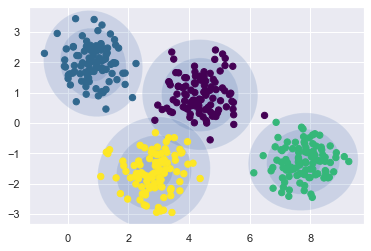

In [20]:
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)

Аналогично можно воспользоваться подходом GMM для "растянутого" набора данных. С учетом полной ковариации модель будет подходить даже для очень продолговартых, вытянутых в длину кластеров:

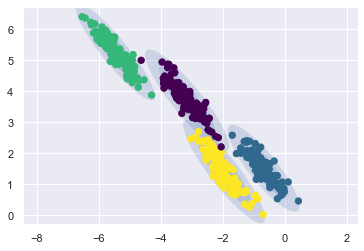

In [22]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

Из этого ясно, что метод GMM решает две известные нам основные практические проблемы метода *k*-средних.
### Выбор типа ковариации
В каждом предыдушем блоке были заданы различные значения параметра **covariance_type**. Этот гиперпараметр управляет степенями свободы форм кластеров. Его значение по умолчанию - **covariance_type="diag"**, означающее возможность независимого задания размеров кластера по всем измерениям с выравниванием полученного эллипса по осям координат.

Более простая и быстрая модель - **covariance_type="spherical"**, ограничивающая форму кластера таким образом, что все измерения равнозначны между собой. Полученная данным образом кластеризация будет аналогична методу *k*-средних.

Вариант с **covariance_type="full"** представляет собой более сложную и требовательную модель (особоенно при росте числа измерений), в которой любой из кластеров может быть эллипсом с произвольной ориентацией.
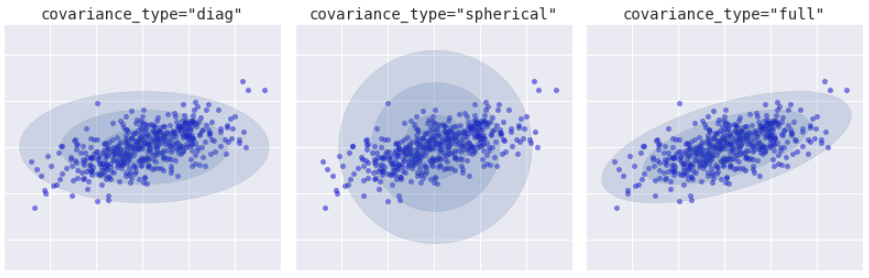

## GMM как метод оценки плотности распределения
Хотя GMM часто относят к алгоритмам кластеризации, по существу, это алгоритм, предназначенный для *оценки плотности распределения*. Таким образом, аппроксимация каких-либо данных методом GMM формально является не моделью кластеризации, а порождающей вероятностной моделью, описывающей распределение данных.

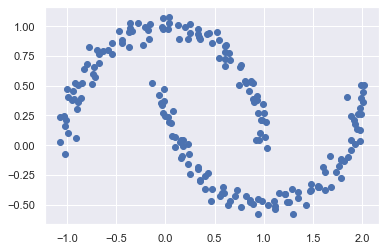

In [23]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

Если мы попытаемся использовать для этих данных двухкомпонентный GMM, рассматриваемый как модель кластеризации, то практическая пригодность результатов окажется сомнительной:

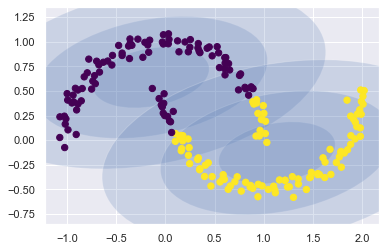

In [25]:
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

Но если взять намного больше компонент и проигнорировать метки кластеров, мы получим намного более подходящую для исходных данных аппроксимацию:

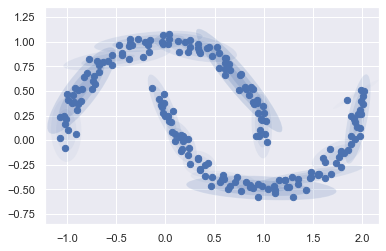

In [26]:
gmm16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

В данном случае смесь 16 нормальных распределений служит не для поиска отдельных кластеров данных, а для моделирования общего *распределения* входных данных. Это прождающая модель распределения, то есть GMM предоставляет нам способ генерации новых случайных данных, распределенных аналогично исходным. Например, вот 400 новых точек, полученных из этой аппроксимации наших исходных данных 16-компонентным алгоритмом GMM:
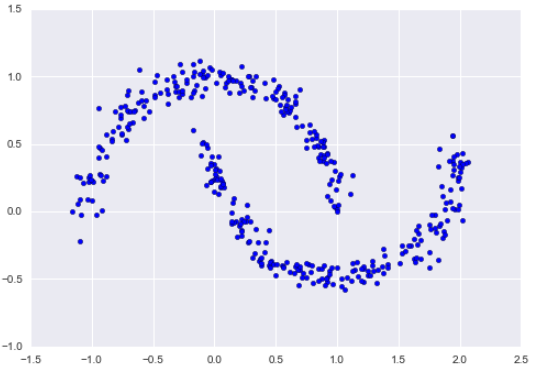

### Сколько компонент необходимо?
Так как GMM - порождающая модель, есть возможность определения оптимального кол-ва компонент для заданного набора данных. Порождающая модель, по существу, представляет собой распределение вероятности для набора данных, поэтому можно легко вычислить *функцию правдоподобия* (likekihood function) для лежащих в ее основе данных, используя перекрестную проверку во избежание переобучения.

C:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


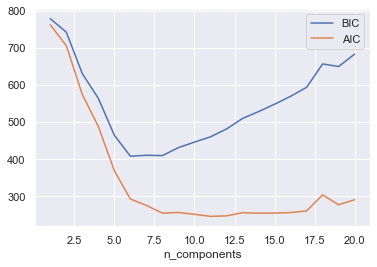

In [30]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

Оптимальное кол-во кластеров - то, которое минимизирует AIC или BIC, в зависимости от требуемой аппроксимации. В данном случае, согласно AIC, лучше взять 8-12.

Подобный метод выбора числа компонент представляет собой меру успешности работы GMM как *оценивателя плотности распределения*, а не как *алгоритма кластеризации*. 
## Пример: использование метода GMM для генерации новых данных

In [31]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

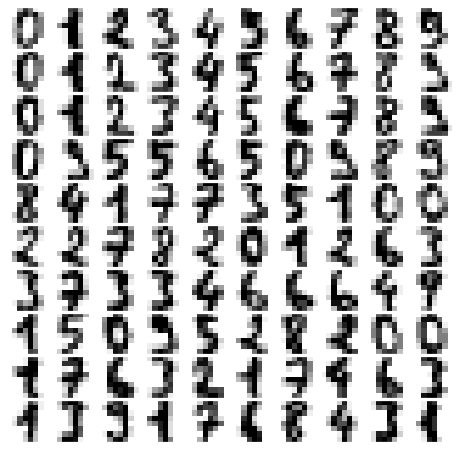

In [32]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

У смеси Гауссовых распределений могут быть проблемы со сходимостью в пространстве столь высокой размерности, применим обратимый алгоритм для понижения размерности данных. Воспользуемся простым РСА с сохранением 99% дисперсии в проекции данных:

In [33]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

Результат оказался 41-мерным, размерность была снижена на 1/3 практически без потери информации. Восп. критерием AIC для определения необходимого кол-ва компонент:

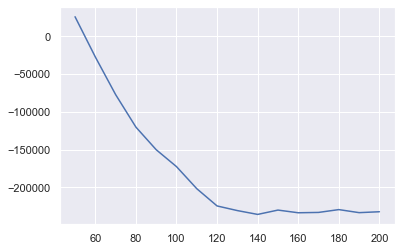

In [35]:
n_components = np.arange(50, 210, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

In [36]:
gmm = GaussianMixture(110, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


In [49]:
# Сгенерируем 100 новых точек в этом 41-мерном пространстве, используя GMM как порождающую модель
data_new = gmm.sample(100)
data_new[0].shape

(100, 41)

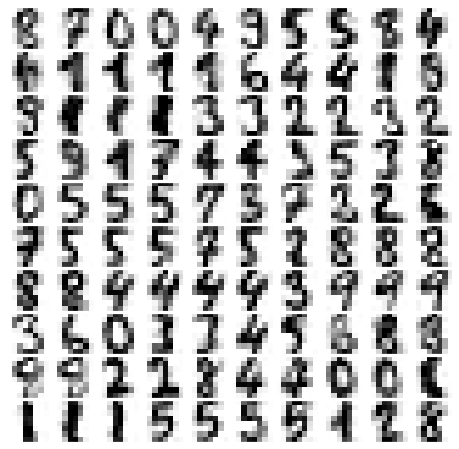

In [51]:
# Обратное преобразование объекта РСА для формирования новых цифр:
digits_new = pca.inverse_transform(data_new[0])
plot_digits(digits_new)

Резюмируем: мы смоделировали распределение для заданной выборки рукописных цифр таким образом, что смогли сгенерировать совершенно новые выборки цифр на основе этих данных: это рукописные цифры, не встречающиеся в исходном наборе данных, но отражающие общие признаки входных данных, смоделированные моделью смеси распределений. Подобная порождающая модель цифр может оказаться очень удобной в качестве компонента байесовского порождающего классификатора.